# LSTM with GloVe Embeddings

Source: https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/#disqus_thread

# Imports and Pre-Processing

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

from numpy import array
from numpy import asarray
from numpy import zeros

import matplotlib.pyplot as plt

Load Dataset

In [ ]:
comments = pd.read_csv("train1_onehot_full.csv")
print(comments.shape)
comments.head(10)

Remove all rows that contain a null value or empty string

In [ ]:
filter = comments["comment_text"] != ""
comments = comments[filter]
comments = comments.dropna()

Print a random comment, and print its associated labels

In [ ]:
print(comments["comment_text"][160])
print("Neutral:" + str(comments["neutral"][160]))
print("Toxic:" + str(comments["toxic"][160]))
print("Derogatory:" + str(comments["derogatory"][160]))

really terrible
Neutral:0
Toxic:1
Derogatory:0


Plot the comment count for each label

In [ ]:
comments_labels = comments[["neutral", "toxic", "derogatory"]]
comments_labels.head()
print(comments_labels.shape)

In [ ]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
plt.title('Dataset balances')

print(comments_labels.sum(axis=0) / 38640)
labels_to_plot = [(comments_labels.sum(axis=0))[0], (comments_labels.sum(axis=0))[1], (comments_labels.sum(axis=0))[2]]
plt.bar(['neutral/positive', 'neg. attitude', 'derogatory'], labels_to_plot, width=0.35, align='center')
plt.ylim(0, 0.7)

In [ ]:
def remove_items(test_list, item):
    # remove the item for all its occurrences
    for i in test_list:
        if(i == item):
            test_list.remove(i)
  
    return test_list

In [ ]:
def preprocess_text(sen):
    sentence = sen.lower()
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remove extra spaces
    sentence = re.sub(' +', ' ', sentence)
    sentence_list = sentence.split()

    # Removing stop words
    stop_words = ['u', 'ur', 'im', 'can', 'cant', 'i', 'me', 'my', 'myself', 'we', 'go', 'our', 'ours', 'ourselves', 'you', "youre", "youve", "youll", "youd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "thatll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "shouldve", 'now', 'd', 'll', 'm', 'o', 're', 'r', 'ur', 've', 'y', 'ain', 'aren', "arent", 'couldn', "couldnt", 'didn', "didnt", 'doesn', "doesnt", 'hadn', "hadnt", 'hasn', "hasnt", 'haven', "havent", 'isn', "isnt", 'ma', 'mightn', "mightnt", 'mustn', "mustnt", 'needn', "neednt", 'shan', "shant", 'shouldn', "shouldnt", 'wasn', "wasnt", 'weren', "werent", 'won', "wont", 'wouldn', "wouldnt"]
    for stop_word in stop_words:
      if stop_word in sentence_list:
        sentence_list = remove_items(sentence_list, stop_word)

    # Join back to list
    sentence = " ".join(sentence_list)

    # Remove extra spaces
    sentence = re.sub(' +', ' ', sentence)
    return sentence.lstrip()

Get a list of all sentences and labels from the dataset

In [ ]:
X = []
sentences = list(comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = comments_labels.values

Split data into training and test sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Tokenizing and GloVe Embeddings

In [ ]:
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
maxlen = 10

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

Get GloVe embeddings. The embedding matrix will be fed into the neural network

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

In [ ]:
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

Specify the model architecture

In [ ]:
print(vocab_size)
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(50)(embedding_layer)
dense_layer_1 = Dense(3, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [ ]:
print(model.summary())

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

# Training and Evaluation

In [ ]:
history = model.fit(X_train, y_train, batch_size=30, epochs=300, verbose=1, validation_split=0.20)

Epoch 1/300
825/825 [==============================] - 8s 8ms/step - loss: 0.5896 - acc: 0.7756 - val_loss: 0.3197 - val_acc: 0.8931
Epoch 2/300
825/825 [==============================] - 6s 7ms/step - loss: 0.3010 - acc: 0.9046 - val_loss: 0.2849 - val_acc: 0.9065
Epoch 3/300
825/825 [==============================] - 6s 7ms/step - loss: 0.2558 - acc: 0.9180 - val_loss: 0.2696 - val_acc: 0.9123
Epoch 4/300
825/825 [==============================] - 6s 7ms/step - loss: 0.2350 - acc: 0.9253 - val_loss: 0.2475 - val_acc: 0.9199
Epoch 5/300
825/825 [==============================] - 6s 7ms/step - loss: 0.2219 - acc: 0.9284 - val_loss: 0.2407 - val_acc: 0.9224
Epoch 6/300
825/825 [==============================] - 5s 7ms/step - loss: 0.2262 - acc: 0.9252 - val_loss: 0.2332 - val_acc: 0.9275
Epoch 7/300
825/825 [==============================] - 5s 7ms/step - loss: 0.2071 - acc: 0.9327 - val_loss: 0.2356 - val_acc: 0.9246
Epoch 8/300
825/825 [==============================] - 5s 7ms/step - 

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

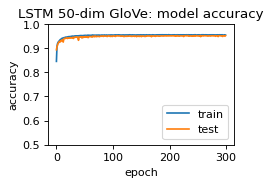

<Figure size 576x432 with 0 Axes>

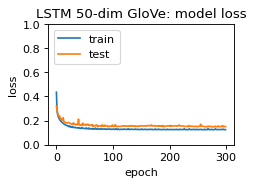

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(3, 2), dpi=80)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('LSTM 50-dim GloVe: model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0.5,1.0))
plt.legend(['train','test'], loc='lower right')
plt.show()

plt.figure()
figure(figsize=(3, 2), dpi=80)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('LSTM 50-dim GloVe: model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim((0,1.0))
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
y_test_labels = np.zeros(y_test.shape[0],)
for i in range(y_test.shape[0]):
  if y_test[i,0] == 1:
    y_test_labels[i] = 0
  elif y_test[i,1] == 1:
    y_test_labels[i] = 1
  elif y_test[i,2] == 1:
    y_test_labels[i] = 2

In [ ]:
predictions = model.predict(X_test)
from sklearn.metrics import confusion_matrix
predict_labels = np.zeros((X_test.shape[0],))
for i in range(predictions.shape[0]):
    idx = np.argmax(predictions[i,:])
    predict_labels[i] = idx
confusion_matrix(y_test_labels, predict_labels, normalize='true')

In [ ]:
from sklearn.metrics import classification_report
from sklearn import metrics
print(classification_report(y_test_labels, predict_labels))
print(confusion_matrix(y_test_labels, predict_labels, normalize='true'))
print("Accuracy:",metrics.accuracy_score(y_test_labels, predict_labels))